In [1]:
import os
import numpy as np
from matplotlib import pyplot as pl

import scipy.io.wavfile as wav
from python_speech_features import mfcc

import mlp_backprop_momentum as mlp
import k_fold_cross_validation as cv

%matplotlib inline

In [2]:
PATH = './vowels/'

SAMPLE_RATE = 24000

N_INITS = 10
N_INPUT_NEURONS = 13
N_HIDDEN_NEURONS = 2
EPOCHS = 100
K = 5
LEARNING_RATE = 0.001
MOMENTUM = 0.5

## Load data, pre-process it and label it

We load every wav file and process them using Mel-Frequency Cepstral Coefficients. We then aggregate the coefficients of each window using an average.

In [3]:
# Compute MFCC for each signal and aggregate windows using the average
def compute_mfcc_average(data):
    return np.average(mfcc(data, samplerate=SAMPLE_RATE, nfft=1024), axis=0)

In [4]:
files = [file for file in os.listdir(PATH) if file.endswith(".wav")]
signals = []

for file in files:
    data = compute_mfcc_average(wav.read(os.path.join(PATH, file))[1])
    signals.append([file[:-4], data])

In [5]:
# Add labels to the list
for signal in signals:
    name = signal[0]
    
    # Natural voice (1) or synthetic (-1)
    signal.append(1 if name[0] == 'n' else -1)
    
    # Kid voice (0), adult female (1) or adult male (-1)
    if name[1] == 'k':
        signal.append(0)
    else:
        signal.append(1 if name[2] == 'f' else -1)

---

---

## Using given code to explore model parameters

We use the code given in notebook `9_model_selection` and make functions to use the code for each step of the practical work.

### Exploring the number of epochs

In [6]:
def explore_nb_epochs(nnp, n_neurons=[2, 4, 8, 10, 12, 15, 20]):
    """Visualize epochs with different numbers of hidden neurons"""
    MSE = np.zeros((len(n_neurons), nnp.n_inits, nnp.epochs))

    for i_h, h in enumerate(n_neurons):                # looping over the number of hidden neurons
        print('Testing', h, 'neurons...')
        nn = mlp.MLP([nnp.n_in, h, nnp.n_out], 'tanh')
        for i in np.arange(nnp.n_inits):               # looping over the initializations
            nn.init_weights()

            MSE[i_h, i, :] = nn.fit((nnp.dataset[:,0:nnp.n_in], nnp.dataset[:,nnp.n_in:nnp.n_in+nnp.n_out]),
                                    learning_rate=nnp.learning_rate,
                                    momentum=nnp.momentum,
                                    epochs=nnp.epochs)

    # Visualize
    pl.figure(figsize=(15,4))
    p_count = 0
    for n in np.arange(MSE.shape[0]):
        pl.subplot(1, MSE.shape[0], n+1)
        for i in np.arange(MSE.shape[1]):
            pl.plot(MSE[n,i,:], c='b')
        pl.ylim(0,1)
        pl.xlabel('Epochs')
        pl.ylabel('MSE')
        pl.title(str(n_neurons[n]) + ' neurons')
        pl.grid()
    pl.tight_layout()

### Exploring the number of hidden neurons

In [7]:
def explore_nb_hidden_neurons(nnp, n_neurons=[2, 4, 6, 8, 10, 15, 20, 25, 30]):
    """Test performance with different numbers of hidden neurons and visualize"""
    MSE_train = np.zeros((len(n_neurons), nnp.epochs, nnp.n_inits))
    MSE_test = np.zeros((len(n_neurons), nnp.epochs, nnp.n_inits))

    for i_h, h in enumerate(n_neurons):                                     # looping the number of hidden neurons
        print('Testing', h, 'neurons...')
        nn = mlp.MLP([nnp.n_in, h, nnp.n_out], 'tanh')
        for i in np.arange(nnp.n_inits):                                        # looping the tests
            nn.init_weights()                                                   # the network has to be reinitialized before each test
            temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,             # notice that we do not use cv.k_fold_cross_validation
                                                                nnp.dataset,    # but cv.k_fold_cross_validation_per_epoch which
                                                                k=nnp.K,        # returns a value of error per each epoch
                                                                learning_rate=nnp.learning_rate,
                                                                momentum=nnp.momentum,
                                                                epochs=nnp.epochs)
            # temp1 and temp2 are the training and test error. One value per epoch
            MSE_train[i_h, :, i] = temp1
            MSE_test[i_h, :, i] = temp2

    # Visualize MSE using two axis
    MSE_train_mean = np.mean(MSE_train, axis=2)
    MSE_test_mean = np.mean(MSE_test, axis=2)
    MSE_train_sd = np.std(MSE_train, axis=2)
    MSE_test_sd = np.std(MSE_test, axis=2)

    v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
    v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

    n_rows = int(np.ceil(len(n_neurons)/3.0))
    pl.figure(figsize=(12,3*n_rows))
    for i_n, n in enumerate(n_neurons):
        pl.subplot(n_rows, min(3, len(n_neurons)), i_n+1)
        pl.fill_between(np.arange(nnp.epochs), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]+MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5, label='Train')
        pl.fill_between(np.arange(nnp.epochs), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]-MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5)
        pl.fill_between(np.arange(nnp.epochs), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]+MSE_test_sd[i_n,:], facecolor='red', alpha=0.5, label='Test')
        pl.fill_between(np.arange(nnp.epochs), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]-MSE_test_sd[i_n,:], facecolor='red', alpha=0.5)
        pl.ylim(0.95*v_min,0.5*v_max)
        pl.ylabel('MSE')
        pl.xlabel('Number of epochs')
        pl.title(str(nnp.K)+'-fold CV with '+str(n)+' hidden neurons')
        pl.legend()
        pl.grid()
    pl.tight_layout()
    
    # Visualize using confusion matrix like plot
    pl.figure(figsize=(15,8))
    pl.subplot(2,1,1)
    pl.imshow(MSE_train_mean, vmin=np.min(MSE_train_mean), vmax=np.percentile(MSE_train_mean, 90), aspect=3, interpolation='nearest')
    pl.yticks(np.arange(len(n_neurons)), n_neurons)
    pl.xlabel('Epochs')
    pl.ylabel('Number of hidden Neurons')
    pl.title('Training')
    pl.colorbar()
    pl.subplot(2,1,2)
    pl.imshow(MSE_test_mean, vmin=np.min(MSE_test_mean), vmax=np.percentile(MSE_test_mean, 90), aspect=3, interpolation='nearest')
    pl.yticks(np.arange(len(n_neurons)), n_neurons)
    pl.xlabel('Epochs')
    pl.ylabel('Number of hidden Neurons')
    pl.title('Test')
    pl.colorbar()
    pl.tight_layout()

### Creating final model and returning the confusion matrix

In [8]:
def final_model_performance(nnp):
    """Build model with final parameters and return performance and confusion matrix"""
    nn = mlp.MLP([nnp.n_in, nnp.n_hidden, nnp.n_out], 'tanh')

    MSE_train, MSE_test, conf_mat = cv.k_fold_cross_validation(nn,
                                                               nnp.dataset,
                                                               k=nnp.K,
                                                               learning_rate=nnp.learning_rate,
                                                               momentum=nnp.momentum,
                                                               epochs=nnp.epochs,
                                                               threshold=nnp.threshold)

    return nn, MSE_train, MSE_test, conf_mat

In [9]:
class NNParameters:
    """Simple container for neural network model parameters"""
    def __init__(self, n_in, n_out, dataset, K, learning_rate, momentum, threshold, n_inits, n_hidden=2, epochs=200):
        # Known before exploration
        self.n_in = n_in
        self.n_out = n_out
        self.dataset = dataset
        self.K = K
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.threshold = threshold
        self.n_inits = n_inits
        
        # Explore different settings
        self.n_hidden = n_hidden
        self.epochs = epochs

---

---

## First experiment

Man vs Woman. Use only the natural voices of men and women to train a neural network that recognizes the gender of the speaker.

In [10]:
# Keep only natural voices
natural_mf = [s for s in signals if s[2] == 1 and s[3] != 0]
print(len(natural_mf))

72


In [11]:
# Extract a list of labels
ceps = [s[1] for s in natural_mf]
labels = [s[3] for s in natural_mf]

# Write dataset
dataset = np.array([np.append(s, l) for s, l in zip(ceps, labels)])

Testing 2 neurons...
Testing 4 neurons...
Testing 8 neurons...
Testing 10 neurons...


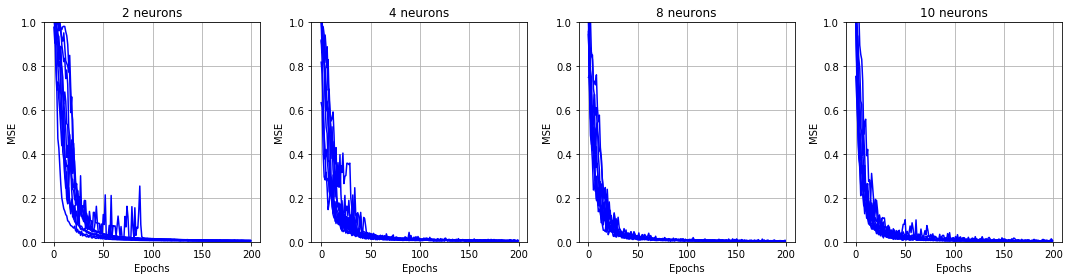

In [12]:
# Build initial parameters set
nn1 = NNParameters(n_in=13,
                   n_out=1,
                   dataset=dataset,
                   K=K,
                   learning_rate=LEARNING_RATE,
                   momentum=MOMENTUM,
                   threshold=0.0,
                   n_inits=N_INITS)

explore_nb_epochs(nn1, [2, 4, 8, 10])

Testing 2 neurons...
Testing 4 neurons...
Testing 8 neurons...
Testing 10 neurons...


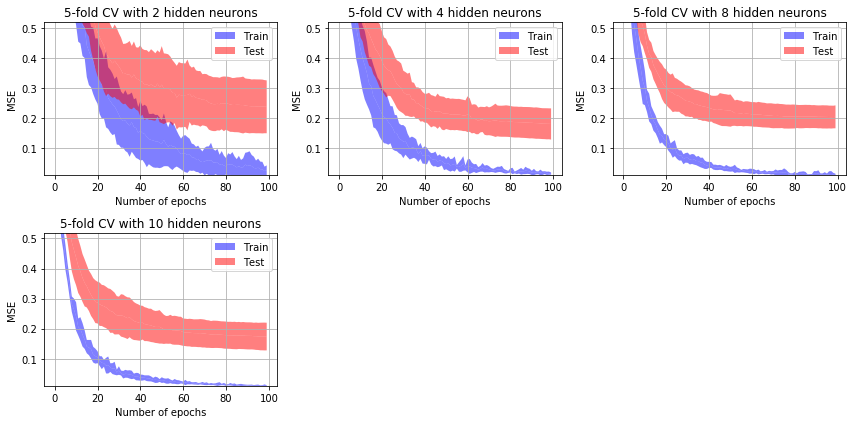

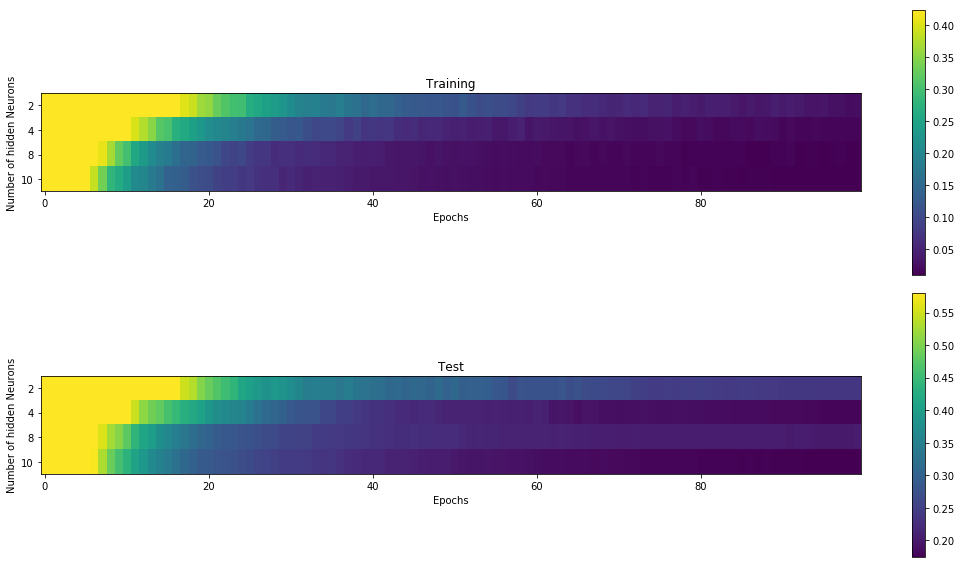

In [13]:
nn1.epochs = 100

explore_nb_hidden_neurons(nn1, [2, 4, 8, 10])

In [14]:
nn1.n_hidden = 8

nn, MSE_train, MSE_test, conf_matrix = final_model_performance(nn1)

print('MSE training: ', MSE_train)
print('MSE test: ', MSE_test)
print('Confusion matrix:')
print(conf_matrix)

MSE training:  0.02466843608052705
MSE test:  0.23161285027202566
Confusion matrix:
[[36.  0.]
 [ 6. 30.]]


## Second experiment

Man vs Woman, using both natural and synthetic voices.

## Third experiment

Man vs. Woman vs. children.

In [15]:
# Code output using three columns
# woman = (1, -1, -1), man = (-1, 1, -1), child = (-1, -1, 1)

## Fourth experiment

Design a final experiment of your choice (e.g., using your own voice). 